# Lab 5 Report:
## Create Arthur Conan Doyle AI with RNN

### Name:

In [25]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions import Categorical

In [26]:
from IPython.display import Image # For displaying images in colab jupyter cell

In [27]:
Image('lab5_exercise.png', width = 1000)

FileNotFoundError: No such file or directory: 'lab5_exercise.png'

FileNotFoundError: No such file or directory: 'lab5_exercise.png'

<IPython.core.display.Image object>

## Prepare Data

In [28]:
# You will train on the first N characters of the Sherlock Holmes book
# Pick the size of your training data, i.e. N
data_size_to_train = 10000

# Load the Sherlock Holmes data up to data_size_to_train
data = open('sherlock.txt', 'r').read()[:data_size_to_train]

# Find the set of unique characters within the training data
characters = sorted(list(set(data)))

# total number of characters in the training data and number of unique characters
data_size, vocab_size = len(data), len(characters)

print("Data has {} characters, {} unique".format(data_size, vocab_size))

Data has 10000 characters, 65 unique


In [29]:
# Use Python Dictionary to map the characters to numbers and vice versa

character_to_num = { ch:i for i,ch in enumerate(characters) }
num_to_character = { i:ch for i,ch in enumerate(characters) }

In [30]:
# Use the character_to_num dictionary to map each character in the training dataset to a number

data = list(data)

for i, ch in enumerate(data):
    data[i] = character_to_num[ch]

## Define Model

In [31]:
class CharRNN(torch.nn.Module):

    def __init__(self, num_embeddings, embedding_dim, input_size, hidden_size, num_layers, output_size):

        super(CharRNN, self).__init__()

        self.embedding = torch.nn.Embedding(num_embeddings, embedding_dim)

        self.rnn = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size,
                                num_layers=num_layers,
                                nonlinearity = 'relu')

        self.decoder = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden_state):

        embedding = self.embedding(input_seq)

        output, hidden_state = self.rnn(embedding, hidden_state)

        output = self.decoder(output)

        return output, hidden_state.detach()

## Define Hyperparameters

In [32]:
# Fix random seed
torch.manual_seed(25)

# Define RNN network
rnn = CharRNN(num_embeddings = vocab_size, embedding_dim = 64,
              input_size = 64, hidden_size = 384, num_layers = 2,
              output_size = vocab_size)


# Define learning rate and epochs
learning_rate = 0.0007
epochs = 80

# Size of the input sequence to be used during training and validation
training_sequence_len = 100
validation_sequence_len = 200

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# add .cuda() for GPU acceleration
rnn

CharRNN(
  (embedding): Embedding(65, 64)
  (rnn): RNN(64, 384, num_layers=2)
  (decoder): Linear(in_features=384, out_features=65, bias=True)
)

## Identify Tracked Values

In [33]:
# Tracking training loss per each input/target sequence fwd/bwd pass
train_loss_list = []

## Train Model

In [34]:
# Convert training data into torch tensor and make it into vertical orientation (N, 1)
# Attach .cuda() if using GPU
data = torch.unsqueeze(torch.tensor(data), dim = 1)

# Training Loop ----------------------------------------------------------------------------------------------------------

for epoch in range(epochs):

    character_loc = np.random.randint(100)

    iteration = 0

    hidden_state = None

    while character_loc + training_sequence_len + 1 < data_size: # loop continues until target_seq reaches end of the data

        # Define input/target sequence
        input_seq = data[character_loc : character_loc + training_sequence_len]
        target_seq = data[character_loc + 1 : character_loc + training_sequence_len + 1]

        # Pass input sequence and hidden_state to RNN
        output, hidden_state = rnn(input_seq, hidden_state)

        # Compute loss between RNN output sequence vs target sequence
        # torch.squeeze removes the column dimension and make them into horizontal orientation
        loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq))

        # Append loss
        train_loss_list.append(loss.item())

        # Empty gradient buffer -> backpropagation -> update network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update starting character for next sequence
        character_loc += training_sequence_len

        # Update iteration number
        iteration += 1

    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-iteration:]))

    # Sample and generate a text sequence after every epoch --------------------------------------------------------------

    character_loc = 0
    hidden_state = None

    rand_index = np.random.randint(data_size-1)
    input_seq = data[rand_index : rand_index+1]

    print("----------------------------------------")

    with torch.no_grad():

        while character_loc < validation_sequence_len: # Loop continues until RNN generated sequence is in desired length

            # Pass validation sequence to RNN
            # Note that RNN now uses its previous output character as input
            output, hidden_state = rnn(input_seq, hidden_state)

            # Take the softmax of the decoder output to get the probabilities of predicted characters
            output = torch.nn.functional.softmax(torch.squeeze(output), dim=0)
            # Use the  probabilities to sample the output character
            character_distribution = torch.distributions.Categorical(output)
            character_num = character_distribution.sample()

            # Convert the character number selected from sampling to actual character and print
            print(num_to_character[character_num.item()], end='')

            # Update the input_seq so that it's using the output of the RNN as new input
            input_seq[0][0] = character_num.item()

            # Update the character location
            character_loc += 1

    print("\n----------------------------------------")

Averaged Training Loss for Epoch  0 :  2.77009646097819
----------------------------------------
yokcir
 caeusrcane te nef".I.nWleM
 Itabeovinto tindur..om pinensaule P lat yime ta he is morae goloy s thet mand aod honos wam he terisinsor loy hith t "leoum
 ols uot turdoctty thew thredesas aH ?on
----------------------------------------
Averaged Training Loss for Epoch  1 :  2.281816187531057
----------------------------------------
dtanture"
an coughert a pisne nommook.satleptinitutven fhe hy ssow uf he Irowed heterthengung Irehormeclcht
 ip to So besrounrtu,im" liunyerteWlan-pf youcgoatt nadhes,
  f Ia Tispot
 oneakle getomed h
----------------------------------------
Averaged Training Loss for Epoch  2 :  2.059724798106184
----------------------------------------
yougorking in toup
 uritoon"ested the has theter antany the war him louis inelomut


 ture. onorerat Sofintanedanithered ny
 my us to than Iade he froelBigove waut sobhan or " fIu.preing astistt toap 
----------------------

## Visualize & Evaluate Model

In [35]:
# Print a validation text sequence that most closely resembles Sherlock Holmes style
rnn.eval()   # put model in evaluation mode

character_loc = 0
hidden_state = None

# Start from a random character in the dataset
rand_index = np.random.randint(data_size - 1)
input_seq = data[rand_index : rand_index + 1]

print("\n--- Sherlock Holmes Style Generated Text ---\n")

with torch.no_grad():  # no learning, just generation

    for _ in range(validation_sequence_len):

        # Forward pass
        output, hidden_state = rnn(input_seq, hidden_state)

        # Convert output to probabilities
        output = torch.nn.functional.softmax(torch.squeeze(output), dim=0)

        # Sample from probability distribution
        character_distribution = torch.distributions.Categorical(output)
        character_num = character_distribution.sample()

        # Convert number to character and print
        print(num_to_character[character_num.item()], end='')

        # Feed output back as next input
        input_seq[0][0] = character_num.item()

print("\n-------------------------------------------")


--- Sherlock Holmes Style Generated Text ---

 Dortsploded that I must either leave toe metropolis
 and rusticate somewhere in the country, or that I must make a
 complete alteration in my style of living. Choosing the latter
 alternative, I bega
-------------------------------------------


In [36]:
# Import seaborn for prettier plot
import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 2.5)

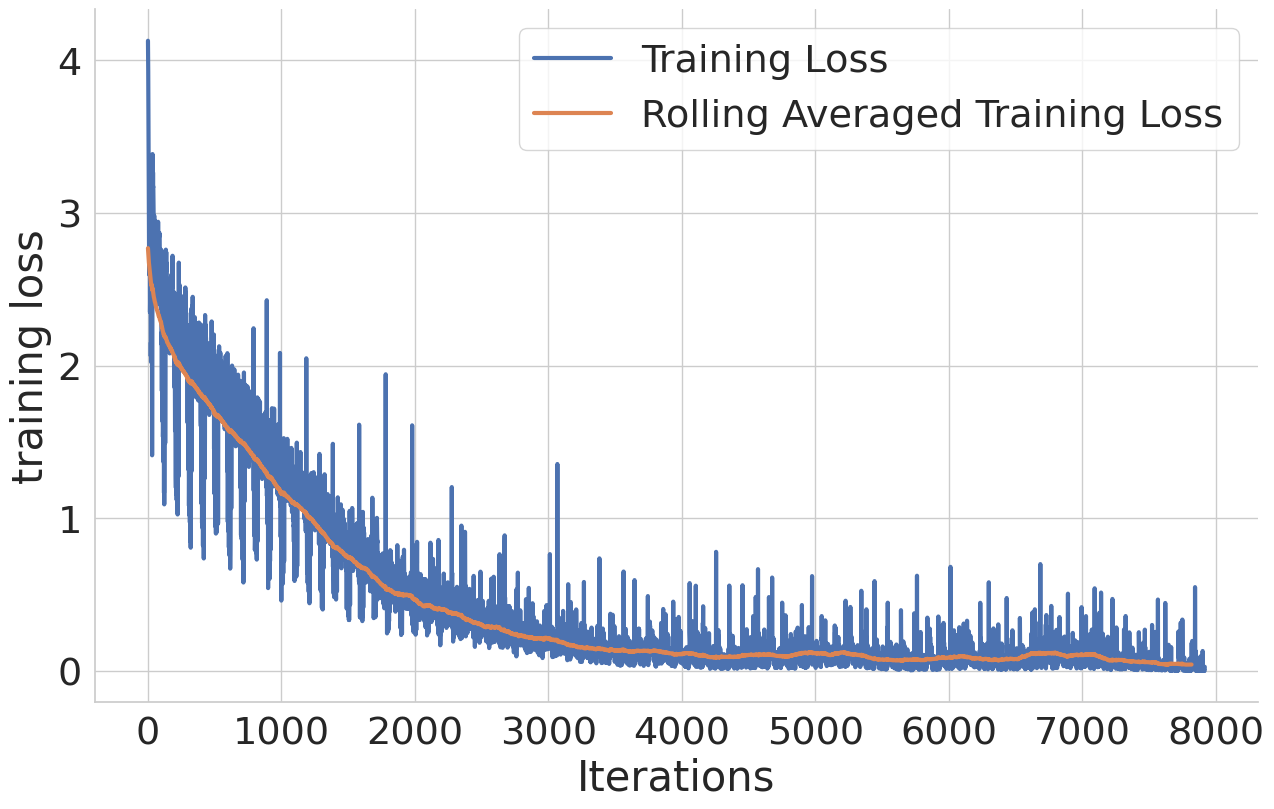

In [37]:
# Plot the training loss and rolling mean training loss with respect to iterations
# Feel free to change the window size
plt.figure(figsize = (15, 9))

plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.plot(np.convolve(train_loss_list, np.ones(100), 'valid') / 100,
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()